In [32]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time

sys.path.insert(0, './src')
sys.path.insert(0, '../rff-reservoir/ext')

import subsample, herding, rptree, rff
from kernelgenerator import compute_kernel
%matplotlib inline

In [33]:
# Download and read MNIST data
import input_data
mnist = input_data.read_data_sets('../rff-reservoir/ext/MNIST')

Extracting ../rff-reservoir/ext/MNIST/train-images-idx3-ubyte.gz
Extracting ../rff-reservoir/ext/MNIST/train-labels-idx1-ubyte.gz
Extracting ../rff-reservoir/ext/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../rff-reservoir/ext/MNIST/t10k-labels-idx1-ubyte.gz


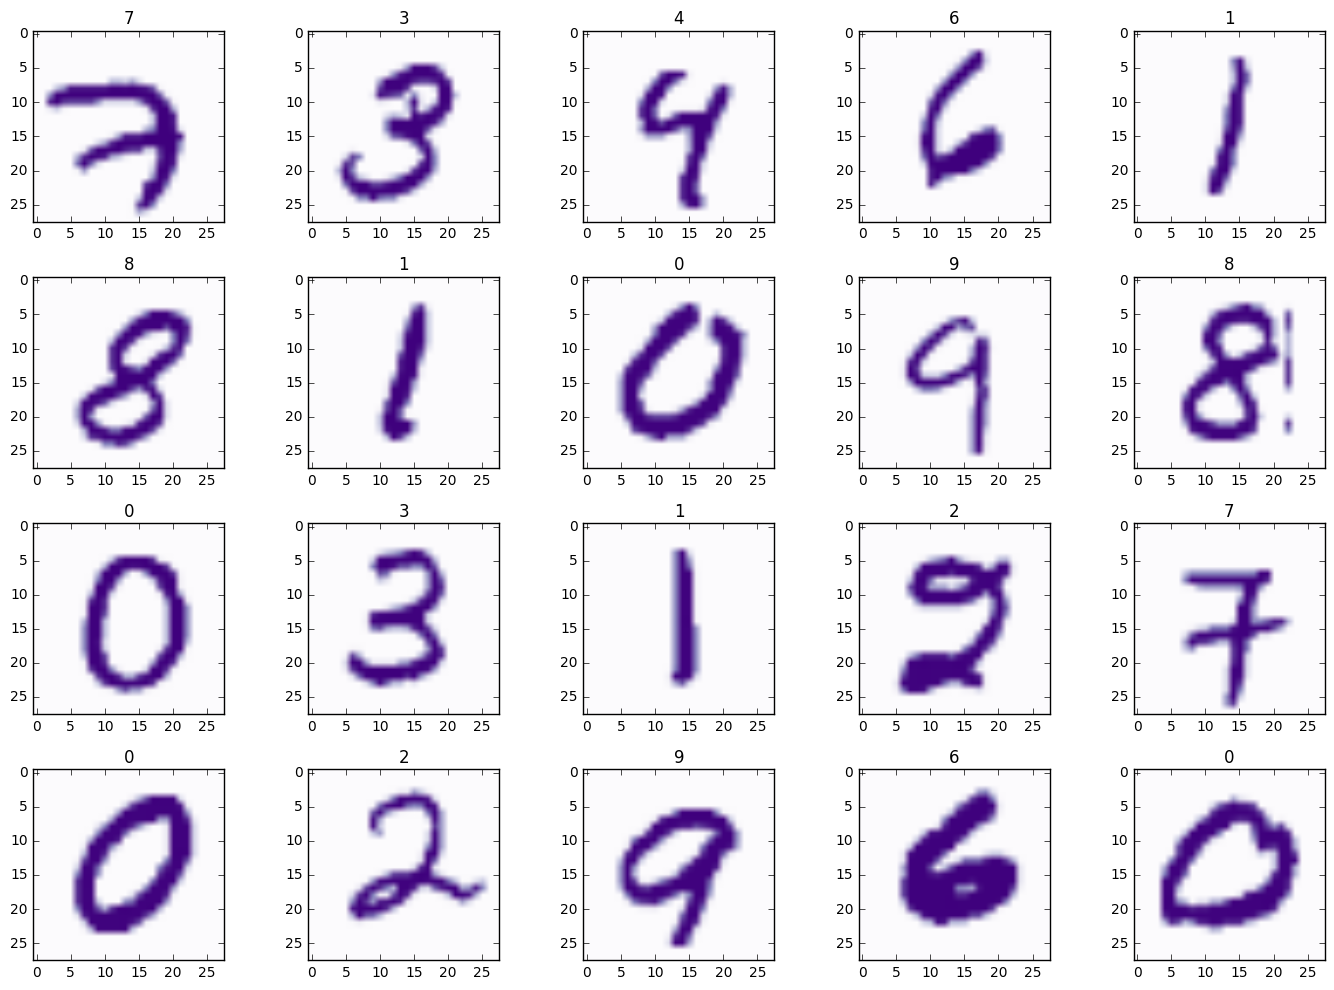

In [34]:
plt.figure(figsize=(14,10))
for i in xrange(20):
    plt.subplot(4,5,i+1)
    plt.imshow(mnist.train.images[i].reshape((28,28)))
    plt.title(mnist.train.labels[i])
    plt.set_cmap('Purples')
plt.tight_layout();

In [35]:
M = 30
N = 50000
D = 500

stream = mnist.train.images[:N]
initial_points = np.array(stream[:M])

#Not sure how this is chosen but I think its gamma
gamma = rff.median_heuristic(initial_points[:100]);

#This phi_hat, ie the vector of random fourier features
phi = rff.RFF(D, initial_points.shape[1], gamma)

In [36]:
from __future__ import division  #So that when we divide by integers we gegt a float. Eg so that 5/2 = 2.5 not 2.
import numpy as np


def online_loss_reg_max(stream, gamma, new_phi, phis_for_criticisms, full_phi_sum, proto_phi_sum, prototype_indices, criticism_indices, n, M, full_stream_phi, N):
    #ONLINE_LOSS_MAX maximizes L(C) online.
    #Here we are adding x_n and assume that stored_phis and full_phi_sum have been updated to include x_new: the new data point.
    
    criticism_indices = np.hstack((criticism_indices,n-1))
    criticism_kernel_matrix = compute_kernel(stream[criticism_indices], M+1, gamma)
    phis_for_criticisms = np.vstack((phis_for_criticisms,new_phi))
    #print phis_for_criticisms.shape
    
    losses = np.zeros(M+1)
    overall_losses = np.zeros(M+1)
    for l in range(M+1):
        #losses[l] = np.abs((1/n)*sum(kernel_matrix[range(n),criticism_indices[l]]) - (1/M)*sum(kernel_matrix[prototype_indices,criticism_indices[l]]))
        #overall_losses[l] = np.abs((1/N)*sum(kernel_matrix[range(N), criticism_indices[l]]) - (1/M)*sum(kernel_matrix[true_proto_indices, criticism_indices[l]]))
        losses[l] = np.abs((1/n)*np.inner(full_phi_sum, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
        #overall_losses[l] = np.abs((1/N)*np.inner(full_stream_phi, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
    
    total_loss = sum(losses)
    F = np.zeros(M+1)
    for y in range(M+1):
        #print criticism_kernel_matrix
        mate = criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]
        #print mate.shape
        r = np.log(np.linalg.det(criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]))
        F[y] = total_loss - losses[y] + r
    #print(sum(overall_losses))
    
    idx_to_exclude = np.argmax(F)
    
    criticism_indices = np.delete(criticism_indices, idx_to_exclude)
    phis_for_criticisms = np.delete(phis_for_criticisms, idx_to_exclude, axis=0)
    
    #print(losses)
    #min_loss_idx = np.argmin(losses)
    #min_loss_idx = np.argmin(overall_losses)
    #min_loss = losses[min_loss_idx]
    #new_loss = losses[M]
    #print(min_loss_idx)
    #print(sum(overall_losses))
    #print(sum(losses))

    #if new_F > min_F:
        #print(criticism_indices)
        #criticism_indices = np.delete(criticism_indices, min_F_idx)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (min_F_idx), axis=0)
        #print phis_for_criticisms.shape
        
    #else:
        #criticism_indices = np.delete(criticism_indices, M)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (M), axis=0)
        #print phis_for_criticisms.shape
        
    olm_return = [criticism_indices, phis_for_criticisms]
    return olm_return

In [37]:
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
#gamma = rff.median_heuristic(stream[:M])
#phi = rff.RFF(500, 2, lengthscale=gamma) 

#kernel_matrix = compute_kernel(stream, N, gamma = 0.029)

#Initialization:
prototype_points = np.array(stream[:M])
criticism_indices = range(M, 2*M)
phis_for_criticisms = phi(np.array(stream[criticism_indices]))

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(prototype_points, phi, logging=True)
full_stream_phi = sum(phi(stream))

#for i in xrange(2*M, len(stream)):
for i in range(2*M, N):
    if np.mod(i, 5000) == 1:
        print i-1
    subsampler.consider(stream[i])
    prototype_indices = subsampler.which
    is_accepted = subsampler.accepted[-1]
    #print (i+1)*subsampler._full_mean_phi
    #print subsampler.total_sum_test
    
    #prototype_indices = np.asarray([5520, 9233, 8410, 2765 ,5408, 7700 ,6251 ,3124, 3154 ,8664])
    
    if not is_accepted:
        olm_return = online_loss_reg_max(new_phi = phi(stream[i]), phis_for_criticisms = phis_for_criticisms, 
                                         full_phi_sum = subsampler.total_sum_test, 
                                         proto_phi_sum = subsampler.sample_sum_test, 
                                         prototype_indices = prototype_indices, 
                                         criticism_indices = criticism_indices, n = i+1, 
                                         M = M, full_stream_phi = full_stream_phi, N = N,
                                         stream = stream, gamma = gamma)
                                         #kernel_matrix = kernel_matrix)
                                         #true_proto_indices = np.asarray([912, 755, 576, 919 ,962, 902 ,775 ,850 ,906, 948]))
        criticism_indices = olm_return[0]
        #print criticism_indices
        #print criticism_indices
        phis_for_criticisms = olm_return[1]
        
print criticism_indices
print prototype_indices

5000
10000
15000
20000
25000
30000
35000
40000
45000
[26216 28096 28818 31684 32572 36404 36740 40364 41555 41588 41821 41953
 42945 43181 43621 44249 44378 46756 46959 47415 49481 49496 49730 49848
 49857 49893 49922 49943 49951 49973]
[   96 26617 27702  4273 29329   217 34607  7661 19126  9426 27750 29169
  5947 19408   847   177  2695    55  8262 12139  1930 26240  1498   254
 35123  8139 49446 28550 21304  1463]


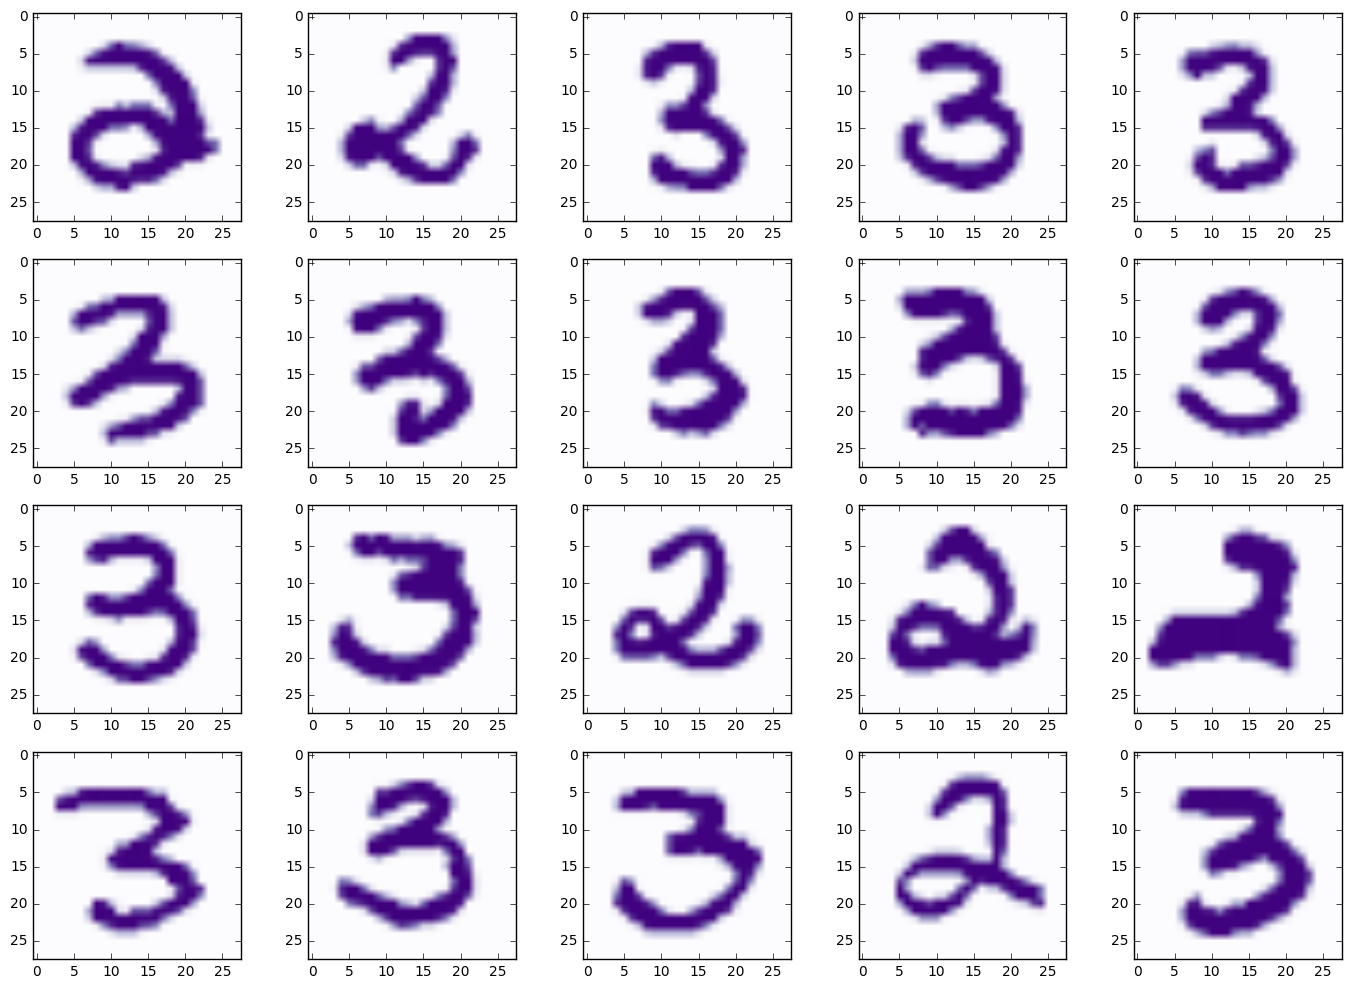

In [38]:
plt.figure(figsize=(14,10))
for i in xrange(20):
    plt.subplot(4,5,i+1)
    plt.imshow(mnist.train.images[criticism_indices[i]].reshape((28,28)))
    #plt.title(mnist.train.labels[i])
    #plt.set_cmap('Purples')
plt.tight_layout();

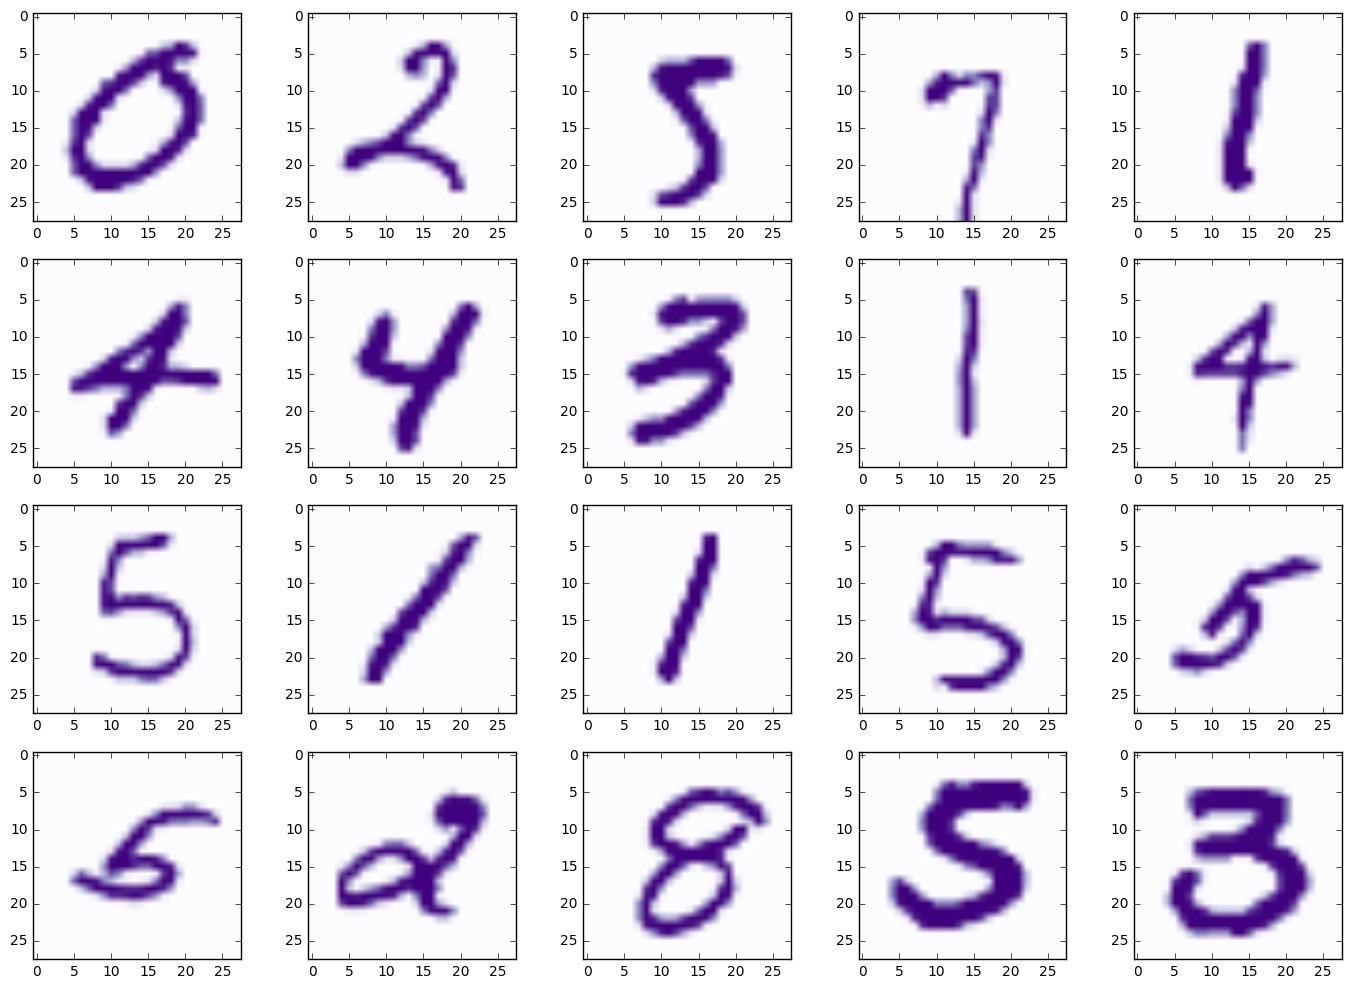

In [39]:
plt.figure(figsize=(14,10))
for i in xrange(20):
    plt.subplot(4,5,i+1)
    plt.imshow(mnist.train.images[prototype_indices[i]].reshape((28,28)))
    #plt.title(mnist.train.labels[i])
    #plt.set_cmap('Purples')
plt.tight_layout();